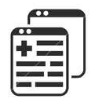
# **Forecasting Patient Cost of Care**
---

Forecasting the cost of care per patient is essential for effective healthcare management. By accurately predicting healthcare costs, providers can allocate resources efficiently, identify high-risk patients, and implement targeted interventions to improve outcomes while minimizing expenses.


Through regression modeling techniques, healthcare stakeholders can enhance decision-making processes and optimize resource utilization, ultimately improving the quality and accessibility of care for all patients.

This project has been created with production in mind, hence the many functions before the main body of the code at the bottom.

The goal of this model is to help our healthcare company accurately predict patient cost. This is based on a real project that was worked on during my tenure at Anthem Blue Cross Blue Shield, with a real sample of the data anonymized and stripped of any personally identifiable information.



In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(path):
  data = pd.read_csv(path)
  return data


We must perform some preprocessing of our data before we can train with it. Because we want to have both categorical and numerical values as features, we'll need to handle them separately and scale/encode them appropriately, while leaving the y target (expenses) alone.

In [3]:
def transform_data(data):
  numeric_features = ['age', 'bmi', 'children']
  categorical_features = ['sex', 'smoker', 'region']

  numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder())
  ])

  # Define separate column transformer for target variable (cost)
  target_transformer = Pipeline(steps=[
      ('passthrough', 'passthrough')
  ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features),
          ('target', target_transformer, ['expenses'])  # Include target variable
      ])

  transformed_data = preprocessor.fit_transform(data)

  # Retrieve the column names after transformation
  numeric_features_scaled = preprocessor.transformers_[0][2]
  categorical_features_encoded = preprocessor.named_transformers_['cat']['encoder']\
                                  .get_feature_names_out(categorical_features)

  # Concatenate column names
  new_column_names = list(numeric_features_scaled) + list(categorical_features_encoded)

  transformed_df = pd.DataFrame(transformed_data, columns=new_column_names + ["expenses"])
  print(transformed_df)
  return transformed_df


In [4]:
def set_x_y(data):
  x = data[['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast',  'region_northwest',  'region_southeast', 'region_southwest']]
  y = data['expenses']
  return x,y


In [5]:
def set_splits(x, y, test_size, random_state):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
  return x_train, x_test, y_train, y_test


In [6]:
def get_best_params(x_train, y_train):
  xgb_regressor = xgb.XGBRegressor()

  param_grid = {
    'xgb__n_estimators': [50, 100, 500],
    'xgb__max_depth': [8, 9, 10],
    'xgb__learning_rate': [0.1, 0.2, 0.3]
  }

  grid_search = GridSearchCV(xgb_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

  grid_search.fit(x_train, y_train)

  best_params = grid_search.best_params_

  best_estimator = grid_search.best_estimator_

  test_score = best_estimator.score(x_test, y_test)

  return best_params, best_estimator, test_score

In [7]:
def train_fit_model(x_train, y_train, learning_rate, max_depth, n_estimators):
  model = xgb.XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators)
  model.fit(x_train, y_train)
  return model

In [8]:
def create_predictions(model, x_test):
  predictions = model.predict(x_test)
  return predictions

In [9]:
def get_metrics(y_test, predictions):
  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print(f"Mean Absolute Error Score: {mae}")
  print(f"Mean Squared Error Score: {mse}")
  print(f"R-Squared Score: {r2}")

  return mae, mse, r2

In [10]:
def save_model(model):
  with open('forecasting_patient_cost_xgbregression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

    print("Model saved successfully.")

In [11]:
path_to_data = '/insurance.csv'
patient_data = get_data(path_to_data)
patient_data.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [12]:
transformed_patient_data = transform_data(patient_data)
transformed_patient_data.tail()
x, y = set_x_y(transformed_patient_data)

           age       bmi  children  sex_female  sex_male  smoker_no  \
0    -1.438764 -0.453646 -0.908614         1.0       0.0        0.0   
1    -1.509965  0.514186 -0.078767         0.0       1.0        1.0   
2    -0.797954  0.382954  1.580926         0.0       1.0        1.0   
3    -0.441948 -1.306650 -0.908614         0.0       1.0        1.0   
4    -0.513149 -0.289606 -0.908614         0.0       1.0        1.0   
...        ...       ...       ...         ...       ...        ...   
1333  0.768473  0.054876  1.580926         0.0       1.0        1.0   
1334 -1.509965  0.202511 -0.908614         1.0       0.0        1.0   
1335 -1.509965  1.022707 -0.908614         1.0       0.0        1.0   
1336 -1.296362 -0.798128 -0.908614         1.0       0.0        1.0   
1337  1.551686 -0.256799 -0.908614         1.0       0.0        0.0   

      smoker_yes  region_northeast  region_northwest  region_southeast  \
0            1.0               0.0               0.0               0.0   

In [13]:
test_size = 0.2
random_state = 42
x_train, x_test, y_train, y_test = set_splits(x, y, test_size, random_state)


In [14]:
best_params, best_estimator, test_score = get_best_params(x_train, y_train)
print(f"Best parameters: {best_params, best_estimator, test_score}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: ({'xgb__learning_rate': 0.1, 'xgb__max_depth': 8, 'xgb__n_estimators': 50}, XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 0.8418554578764859)


In [15]:
learning_rate = best_params['xgb__learning_rate']
max_depth = best_params['xgb__max_depth']
n_estimators = best_params['xgb__n_estimators']
model = train_fit_model(x, y, learning_rate, max_depth, n_estimators)
# model = train_fit_model(x, y, 0.3, 10, 100) # test

In [16]:
predictions = create_predictions(model, x_test)
mae, mse, r2 = get_metrics(y_test, predictions)

Mean Absolute Error Score: 1569.5000439999708
Mean Squared Error Score: 8299501.813832562
R-Squared Score: 0.9465406150852972


In [17]:
patient_data['expenses'].describe()

count     1338.000000
mean     13270.422414
std      12110.011240
min       1121.870000
25%       4740.287500
50%       9382.030000
75%      16639.915000
max      63770.430000
Name: expenses, dtype: float64

Given the metrics above, we can see our model is performing relatively well. Our estimates for expenses tend to be off on average by about $1,500.

This is good considering that we're dealing with a mean cost of about $13,000, which is good considering that we're dealing with minimums of ~1,000 and maximums of ~64,000.

We can also see in the below scatterplot a visual of how our regressor performs. Our predicted values fit well with the true values.

We want to be careful not to overfit, as an r^2 score too close to 1 would indicate. But we can see that isn't the case here with our predicted vs true values between the true values of 2,000 to 4,000. These values were harder to predict, but overall still fits the relationship trend.

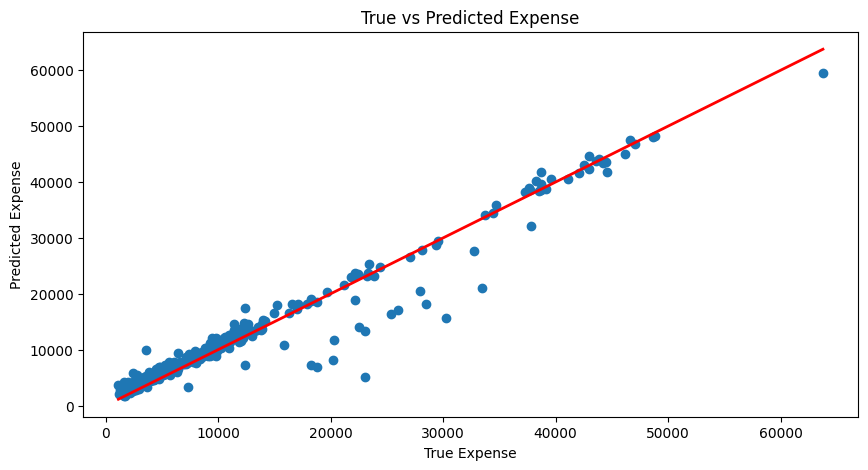

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Expense')
plt.ylabel('Predicted Expense')
plt.title('True vs Predicted Expense')
plt.show()

Another performance metric we can use to visualize how well our model does is a distribution of residuals plot. We can see that most of our residuals group up around 0, which is good, because it means that the difference between our predicted and true values is small. However, we would not want them to all be at 0, because that would indicate overfitting, which we see here isn't the case.

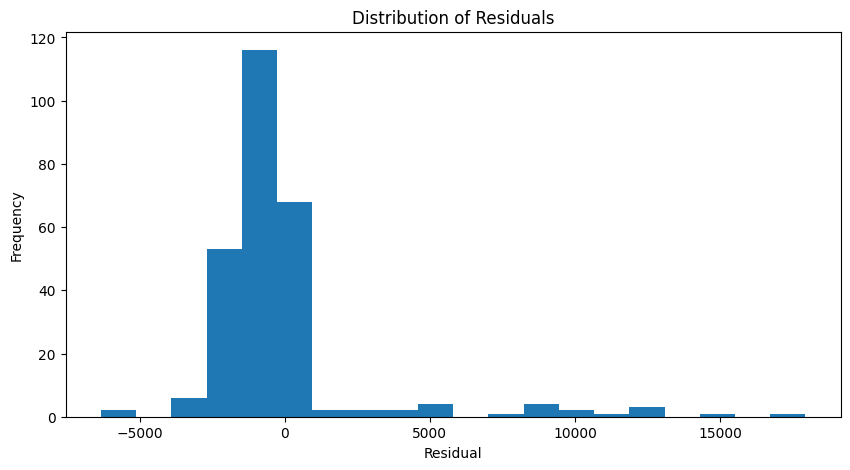

In [19]:
residuals = y_test - predictions

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

So what lead to the high accuracy of the model? We can see from analyzing the feature importances, that smoking is a very important indicator.

This may seem obvious already. You can ask most people if patient cost correlates with smoking, and most will likely say it does. But can they say by how much?

With our model, we can predict with a degree of precision what those higher and lower expenses will look like for smokers and non-smokers. From a business perspective, we can use these numbers to confirm our intution and prepare financially for patient cost with confidence.

Feature 1: age, Importance: 0.0101
Feature 2: bmi, Importance: 0.0144
Feature 3: children, Importance: 0.0031
Feature 4: sex_female, Importance: 0.0015
Feature 5: sex_male, Importance: 0.0000
Feature 6: smoker_no, Importance: 0.9598
Feature 7: smoker_yes, Importance: 0.0000
Feature 8: region_northeast, Importance: 0.0030
Feature 9: region_northwest, Importance: 0.0048
Feature 10: region_southeast, Importance: 0.0015
Feature 11: region_southwest, Importance: 0.0018


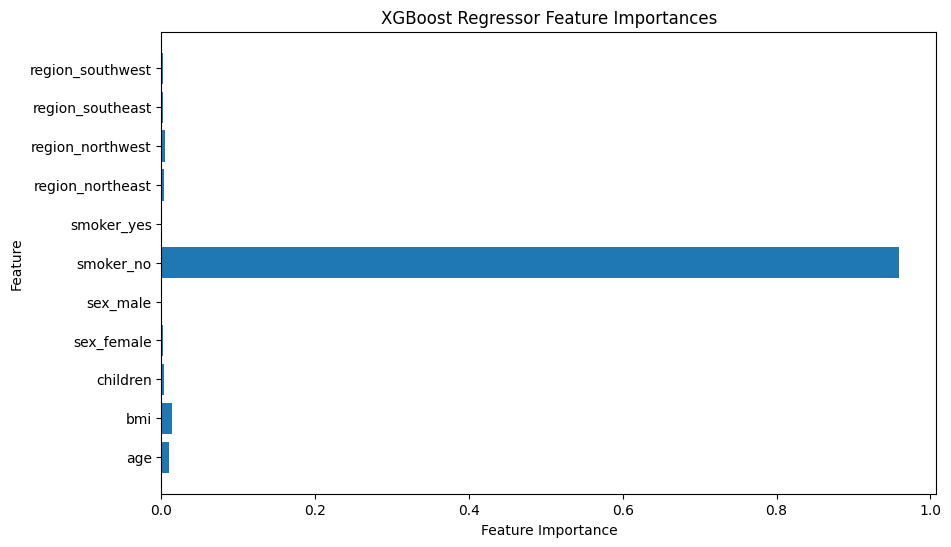

In [20]:
importances = model.feature_importances_

feature_names = x_train.columns

for i, (importance, feature_name) in enumerate(zip(importances, feature_names), 1):
    print(f"Feature {i}: {feature_name}, Importance: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Regressor Feature Importances')
plt.show()

To wrap up, let's save our data for retrieval use in production.

In [21]:
save_model(model)

Model saved successfully.
